<a href="https://colab.research.google.com/github/rory-smith/Lectures-on-inference-in-GW-astronomy/blob/master/GW_data_in_a_toy_universe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [222]:
import requests, os
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'


In [5]:
!pip install lalsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install latex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [223]:
import lalsimulation as lalsim
import numpy as np
from scipy import stats
import pylab as plt
import lal
import pandas as pd
from scipy.special import logsumexp
#plt.rcParams['text.usetex'] = True

#plt.rcParams.update({
#    "text.usetex": True,
#   "font.family": "sans-serif",
#    "font.sans-serif": ["Helvetica"]})

In [224]:
def GW_detector_noise(N):


  deltaF = 1/4.
  noise_mean = 0
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(150) / (4*deltaF)

  noise_re = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))
  noise_imag = np.random.normal(loc=noise_mean, scale=np.sqrt(noise_var), size=int(N))

  return noise_re + 1j*noise_imag

In [225]:
def draw_mtotal(N):

  mtot_min = 30
  mtot_max = 100
  mtot_mean = 60
  mtot_var = 10
  a = (mtot_min-mtot_mean)/np.sqrt(mtot_var) # some annoying parameter for scipy function
  b = (mtot_max-mtot_mean)/np.sqrt(mtot_var)
  return stats.truncnorm.rvs(a, b, loc=mtot_mean, scale=np.sqrt(mtot_var),size=int(N))

In [226]:
# this is all bookkeepy stuff to allow us to evaluate a GW signal at GW frequency of 150Hz #####
f = np.array([150])
F = f#np.loadtxt("Freqs_long.txt")
F = lal.CreateREAL8Vector(len(F))
F.data[:] =  f
###############################################################################
def GW_signal(Mtotal):

  mass_ratio = 1 #all binaries in our universe contain equal-mass black holes
  Dist = 1e6*lal.lal.PC_SI #all binary black holes are located 0.1Gpc from our detector
  spin1x, spin1y, spin1z = 0, 0, 0 #black holes do not spin in our Universe
  spin2x, spin2y, spin2z = 0, 0, 0 #black holes do not spin in our Universe
  iota = 0 #all BBH obits are inclined such that their orbital plane is "face on"

  m1, m2 = Mtotal/(1+mass_ratio), Mtotal/(1+mass_ratio)

  m1 *= lal.lal.MSUN_SI #component mass into SI units
  m2 *= lal.lal.MSUN_SI
  WFdict = lal.CreateDict() #bookkeepy thing
  h = lalsim.SimIMRPhenomXPHMFrequencySequence(F, m1, m2, spin1x, \
            spin1y, spin1z, spin2x, spin2y, spin2z, Dist, iota, 0, 150, WFdict)
  
  signal = h[0].data.data + h[1].data.data #equal parts plus and cross polarization
  return signal

In [245]:
noise_measurements = GW_detector_noise(5e6)

In [246]:
BBH_masses = draw_mtotal(5e6)

In [247]:
signals = np.array([GW_signal(_m)[0] for _m in BBH_masses])

In [248]:
strain_data = signals + noise_measurements

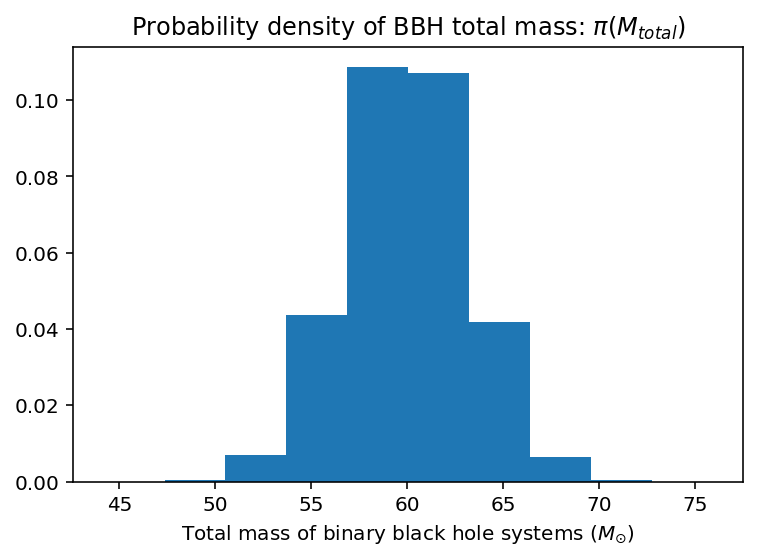

In [249]:
plt.hist(BBH_masses, density=True)
plt.xlabel(r"Total mass of binary black hole systems $(M_{\odot})$")
plt.title(r"Probability density of BBH total mass: $\pi(M_{total})$")
plt.show()

In [250]:
## bundle up our data, noise, masses into a pandas data frame 
_df = {'total mass':BBH_masses, 'strain_data':strain_data, 'noise':noise_measurements}
dataframe = pd.DataFrame(data=_df)

In [251]:
dataframe

,total mass,strain_data,noise
0,57.726832,-4.133063e-21+1.263582e-23j,-2.795013e-24-6.655436e-24j
1,64.188565,-4.735644e-21+3.045352e-23j,-2.980832e-24+4.138991e-24j
2,57.305838,-4.085451e-21+5.497663e-24j,7.880106e-24-1.339533e-23j
3,59.245109,-4.258897e-21+8.150264e-24j,6.838993e-24-1.262227e-23j
4,54.763213,-3.863837e-21+2.062228e-23j,1.195758e-23+4.044228e-24j
...,...,...,...
4999995,56.169565,-3.995202e-21+1.526930e-23j,-2.420767e-25-2.571559e-24j
4999996,58.894147,-4.224474e-21+1.468498e-23j,9.628349e-24-5.738320e-24j
4999997,59.358623,-4.279922e-21+3.169139e-23j,-3.912775e-24+1.080495e-23j
4999998,63.091405,-4.622217e-21+1.618481e-23j,3.284817e-24-8.776208e-24j


In [252]:
strain_data_new = GW_detector_noise(1) + GW_signal(55)

In [262]:
precision = 24 #number of decimal places to round data

idx = np.where(np.around(strain_data,precision)==np.around(strain_data_new, precision))

In [290]:
# the part of the dataframe where the strain data equals the new data (to our set precision)
measurement_table = dataframe[dataframe.index.isin(idx[0])]

In [291]:
# this contains the total masses that produce strain data equal to what we just "measured"
# with this, we can estimate the probability of a the total mass given our newly measured data by counting  
measurement_table

,total mass,strain_data,noise
9403,55.134752,-3.913296e-21+2.041617e-23j,-6.291493e-24+3.508267e-24j
62276,55.118848,-3.913194e-21+1.967524e-23j,-7.529141e-24+2.781526e-24j
73562,55.201606,-3.913431e-21+1.953096e-23j,-7.900969e-25+2.563434e-24j
115891,55.096093,-3.913246e-21+2.032747e-23j,-9.497504e-24+3.454008e-24j
188724,55.230513,-3.913138e-21+1.962137e-23j,1.942018e-24+2.628040e-24j
...,...,...,...
4688035,55.260135,-3.912814e-21+2.037170e-23j,4.766479e-24+3.351917e-24j
4776017,55.240326,-3.912720e-21+2.034180e-23j,3.188450e-24+3.339704e-24j
4799996,55.164651,-3.913294e-21+1.990919e-23j,-3.768929e-24+2.974647e-24j
4868631,55.046323,-3.913027e-21+2.047833e-23j,-1.346807e-23+3.649165e-24j


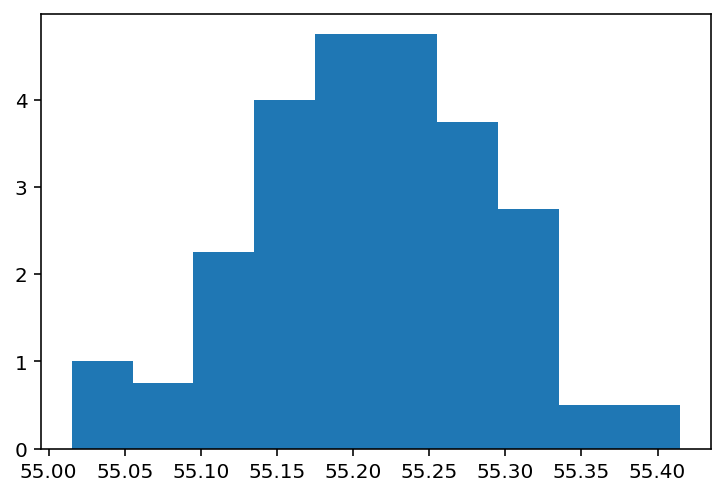

In [292]:
plt.hist(measurement_table['total mass'],density=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:905: ComplexWarning: Casting complex values to real discards the imaginary part
  db = np.array(np.diff(bin_edges), float)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:789: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)
/usr/local/lib/python3.7/dist-packages/matplotlib/transforms.py:1969: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = float(x), float(y)


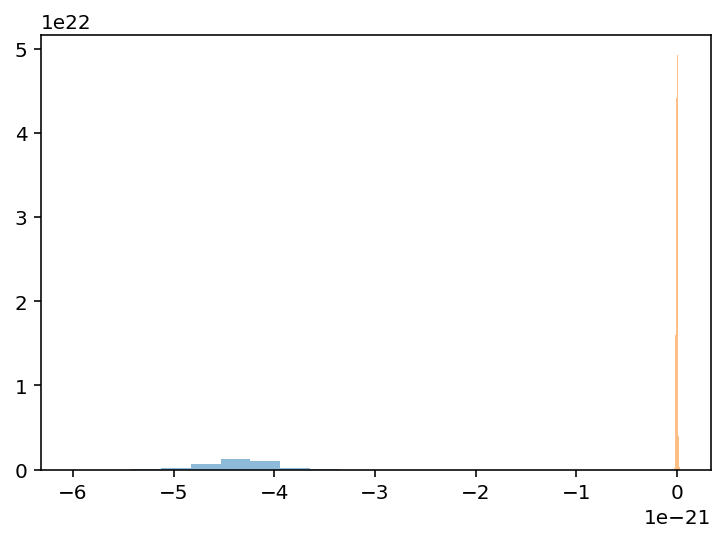

In [266]:
plt.hist(strain_data,density=True,alpha=0.5)
plt.hist(noise_measurements,density=True,alpha=0.5)
plt.show()

In [267]:
def lnL(data,mtotal):
  deltaF = 1/4.
  noise_mean = 0
  noise_var = lalsim.SimNoisePSDaLIGOZeroDetLowPower(150) / (4*deltaF)

  signal = GW_signal(mtotal)[0]
  return stats.norm.logpdf(data, loc=signal, scale=np.sqrt(noise_var))

def lnpi(mtotal):
  mtot_min = 30
  mtot_max = 100
  mtot_mean = 60
  mtot_var = 10
  a = (mtot_min-mtot_mean)/np.sqrt(mtot_var) # some annoying parameter for scipy function
  b = (mtot_max-mtot_mean)/np.sqrt(mtot_var)
  return stats.truncnorm.logpdf(mtotal,a, b, loc=mtot_mean, scale=np.sqrt(mtot_var))


In [268]:
def ln_p_mtotal_given_data(mtotal, data):

  return lnpi(mtotal) + lnL(data, mtotal)

In [283]:
m_tot_list = np.linspace(54.9,55.5,10000)
lnp = np.array([ln_p_mtotal_given_data(_m,strain_data_new) for _m in m_tot_list])
ln_evidence = logsumexp(lnp,b=(m_tot_list[1]-m_tot_list[0]))

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


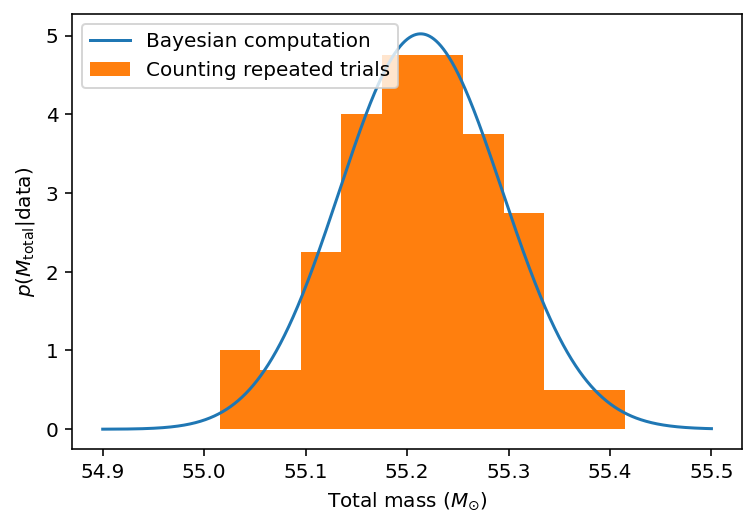

In [293]:
plt.plot(m_tot_list, np.exp(lnp)/np.exp(ln_evidence),label='Bayesian computation')
plt.hist(measurement_table['total mass'],density=True,label='Counting repeated trials')
plt.legend(loc=2)
plt.xlabel("Total mass ($M_{\odot})$")
plt.ylabel("$p(M_{\mathrm{total}}|$data)")
plt.show()